# Analysis of the Power Consumption Dataset

In this notebook, we demonstrate the *Multi-Component Feature DTW transformation* with an interactive prototype selection using the power consumption dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt

pd.set_option("plotting.backend", "matplotlib")


SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

plt.style.use("seaborn-notebook")

## Loading of the Preprocessed Dataset

Firstly we load extracted seasonalities, trends, and the original power consumption curves.

In [4]:
DATA_PATH = Path("../power_consumption_data")

In [5]:
start_time = time.time()
(
    free_day,
    work_day,
    spring_week,
    summer_week,
    autumn_week,
    winter_week,
    year,
    trend,
) = [
    pd.read_parquet(DATA_PATH / f"{x}.snappy.parquet")
    for x in tqdm(
        (
            "free_day",
            "work_day",
            "spring_week",
            "summer_week",
            "autumn_week",
            "winter_week",
            "year",
            "trend",
        )
    )
]

time.time() - start_time

  0%|          | 0/8 [00:00<?, ?it/s]

1.785499095916748

In [6]:
start_time = time.time()
print("Loading dataset...")
time_series = pd.read_parquet(DATA_PATH / "kwh_hours.snappy.parquet")

print(f"Done {time.time() - start_time}")

start_time = time.time()
print("Converting datetimes...")
time_series.columns = pd.to_datetime(time_series.columns)

print(f"Done {time.time() - start_time}")

Loading dataset...
Done 9.012877941131592
Converting datetimes...
Done 0.009076356887817383


Then we compute statistical properties from our curves. We will use them later in combination with Multi-Component Feature DTW transformation.

In [7]:
resampled_days = (time_series.T.resample("d").mean() * 24).T

year_agg = resampled_days.T.resample("y")
year_diff = resampled_days.diff(axis=1).T.resample("y")

In [8]:
# Statistical properties per year
quantiles = [0.25, 0.5, 0.75]
year_stats = year_agg.quantile(quantiles)[:3].T
year_stats.columns = quantiles

year_stats["iqr"] = year_stats[0.75] - year_stats[0.25]

In [9]:
# Statistical features using the first derivative of the original power
# consumtion curves
quantiles = [0.25, 0.5, 0.75]
year_diff_stats = year_diff.quantile(quantiles)[:3].T
year_diff_stats.columns = quantiles

year_diff_stats["iqr"] = year_diff_stats[0.75] - year_diff_stats[0.25]

In [10]:
# Selecting sample of our dataset
random_ts = time_series.sample(5000, random_state=42)

In [11]:
# Z-normalization of sessonalities and trends
dimensions = [
    free_day,
    work_day,
    spring_week,
    summer_week,
    autumn_week,
    winter_week,
    year,
    trend,
]

dimensions = [
    x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0).iloc[random_ts.index]
    for x in dimensions
]

## Multi-Component Feature DTW Transformation

Now, we apply the Multi-Component Feature DTW transformation to our dataset using 30 randomly selected prototypes.

In [12]:
from dtaidistance import dtw

from feature_dtw import MultiComponentFDTWTransformer
from feature_dtw.metrics import dd_distance
from feature_dtw.notebook import FeatureDTWTransformer

In [13]:
n_components = 30

mcfdtw = MultiComponentFDTWTransformer(
    n_transformers=[
        FeatureDTWTransformer(
            n_components=n_components,
            random_state=42,
            metric=dd_distance,
            metric_param=dict(
                a=0.5,
                distance=dtw.distance_fast,
                use_pruning=True,
                window=-1,
            ),
        )
        for _ in dimensions
    ]
)

In [14]:
mcfdtw.fit(dimensions)

In [15]:
feature_data = mcfdtw.transform(dimensions)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Because our features have a high diversity of values on both positive and negative spectrum, we are using the `arcsinh` function as it has similar properties to `log` but can handle non-positive values.

In [16]:
fdtw_data = np.arcsinh(
    np.hstack(
        [
            feature_data,
            year_stats.iloc[random_ts.index],
            year_diff_stats.iloc[random_ts.index],
        ]
    )
)

### Scaling, PCA, UMAP

In the next step, we prepare Standard Scaler as feature matrices from different components, and statistical properties of power consumption curves have an entirely different scale.

Then we use PCA and UMAP to prepare data for further processing and visualization. We are using UMAP as a helper for density-based clustering to overcome the curse of dimensionality (https://umap-learn.readthedocs.io/en/latest/clustering.html).

After adding new prototypes please execute all cells bellow.

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

In [18]:
scaler = StandardScaler()

pca = PCA(random_state=42)
umap_high = UMAP(n_components=10, metric="manhattan", densmap=True, random_state=42)
umap = UMAP(n_components=2, densmap=True, random_state=42)

In [19]:
X_scaled = scaler.fit_transform(feature_data)

In [20]:
X_pca = pca.fit_transform(X_scaled)

In [21]:
start_time = time.time()
print("Transforming UMAP - high...")
X_umap_high = umap_high.fit_transform(X_pca[:, :50])
print(f"Done {time.time() - start_time}")

Transforming UMAP - high...
Done 67.9547848701477


In [22]:
start_time = time.time()
print("Transforming UMAP - 2...")
X_umap = umap.fit_transform(X_umap_high)
print(f"Done {time.time() - start_time}")

Transforming UMAP - 2...
Done 43.93878173828125


### Clustering and Anomaly Detection

For clustering we are using a HDBSCAN and K-means clustering algorithms.

In [23]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [24]:
kmeans = KMeans(
    n_clusters=10,
)

We are detecting points closest to the cluster centers as we can use them as new prototypes in the next iteration of our pipeline

In [25]:
predicted_kmeans = kmeans.fit_predict(X_pca[:, :100])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_pca[:, :100])

In [26]:
closest

array([3430, 1946, 3251, 2161, 2152, 1079, 2783, 4136, 1387, 1435])

In [27]:
np.unique(predicted_kmeans, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([359, 426, 427, 291, 440, 625, 358, 756, 798, 520]))

In [28]:
hdb = HDBSCAN(min_cluster_size=30)

In [29]:
predicted_hdb = hdb.fit_predict(X_umap_high)

In [30]:
np.unique(predicted_hdb, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([ 514, 2457,   60,  356,  951,  662]))

For anomaly detection we are using LODA and Isolation Forest methods. We can use `anomly_score` for coloring data points in the next.

In [31]:
from anlearn.loda import LODA
from sklearn.ensemble import IsolationForest

In [32]:
loda = LODA(n_estimators=1000, random_state=42)
iforest = IsolationForest(n_estimators=1000, random_state=42)

In [33]:
loda.fit(X_scaled)
anomaly_score_loda = loda.score_samples(X_scaled)

In [34]:
iforest.fit(X_scaled)
anomaly_score_ifo = iforest.score_samples(X_scaled)

## Visualization of the Power Consumption Dataset

After the initial feature space building using the random prototypes, we are using data visualization for selecting new prototypes.

In [35]:
from dataclasses import dataclass
from itertools import chain, repeat
from typing import Any, Dict, Union

from bokeh.io import curdoc, output_notebook, push_notebook, show
from bokeh.layouts import column, gridplot, row
from bokeh.models import (
    BooleanFilter,
    CDSView,
    ColorBar,
    ColumnDataSource,
    Legend,
    LegendItem,
    Select,
)
from bokeh.palettes import Category10, Category20, Inferno256, Magma256, Spectral11
from bokeh.plotting import figure
from bokeh.transform import factor_cmap, factor_mark, linear_cmap
from lttb import downsample

output_notebook()

Loading BokehJS ...

In [36]:
# Helper class and constants


@dataclass
class PlotOptions:
    legend_items: Union[str, Dict[str, Any]]
    mark: Union[str, Dict[str, Any]]
    color: Union[str, Dict[str, Any]]
    legend_name: str
    color_bar_vis: bool = False
    legend_vis: bool = True


TOOLTIPS = [
    ("index", "$index"),
    ("Prototype", "@Prototype"),
    ("Clustering Group", "@Clustering"),
    ("Manual Group", "@Manual"),
    ("Anomaly Score", "@Anomaly"),
]

PLOT_NAMES = ["UMAP", "PCA"]
MARKERS = [
    "circle",
    "asterisk",
    "cross",
    "diamond",
    "hex",
    "square",
    "star",
    "triangle",
    "circle_cross",
    "diamond_cross",
    "inverted_triangle",
    "square_cross",
    "circle_x",
    "square_x",
]

COLORING_FIELDS = ["Prototype", "Manual Grouping", "Clustering", "Anomaly Score"]

Dataset definition for Bokeh visualization. After we add new prototypes, it is necessary to reload the dataset to apply it in our visualization.

In [37]:
try:
    frame.loc[:, ["X_umap", "Y_umap"]] = X_umap[:, :2]
    frame.loc[:, ["X_pca", "Y_pca"]] = X_pca[:, :2]
except NameError:

    # Preparing dataset for Bokeh
    frame = pd.DataFrame(
        np.hstack(
            [
                X_umap[:, :2],
                X_pca[:, :2],
            ]
        ),
        columns=["X_umap", "Y_umap", "X_pca", "Y_pca"],
    )
    frame["Manual"] = "0"

frame["Prototype"] = False
frame.loc[mcfdtw.transformers[0].index_, "Prototype"] = True

frame["Clustering"] = predicted_kmeans.astype(str)
frame["Anomaly"] = anomaly_score_loda

source = ColumnDataSource(frame)
prototypes = CDSView(source=source, filters=[BooleanFilter(frame.Prototype)])

In [38]:
# Bokeh App definition
def bkapp(doc):
    plots = [
        figure(
            tools=["lasso_select", "wheel_zoom", "pan", "reset", "hover"],
            active_drag="pan",
            active_scroll="wheel_zoom",
            title=name,
            x_axis_label="X",
            y_axis_label="Y",
            output_backend="webgl",
            tooltips=TOOLTIPS,
        )
        for name in PLOT_NAMES
    ]

    scatters = [
        plot.scatter(
            f"X_{name.lower()}",
            f"Y_{name.lower()}",
            alpha=0.8,
            size=5,
            source=source,
        )
        for name, plot in zip(PLOT_NAMES, plots)
    ]

    scatter_prot = [
        plot.scatter(
            f"X_{name.lower()}",
            f"Y_{name.lower()}",
            marker="hex_dot",
            size=15,
            alpha=0.3,
            color="black",
            source=source,
            view=prototypes,
        )
        for name, plot in zip(PLOT_NAMES, plots)
    ]

    prot_leg_item = LegendItem(label="Prototype", renderers=plots[1].renderers[1:])

    legend = Legend(
        title="Datapoint Types:",
        items=[
            LegendItem(label="Prototype", renderers=plots[1].renderers[1:]),
            LegendItem(label="Data Point", renderers=plots[1].renderers[:1]),
        ],
    )

    legend.title_text_font_style = "bold"

    plots[1].add_layout(legend, "right")

    mapper_anomaly = linear_cmap(
        field_name="Anomaly",
        palette=Inferno256,
        low=np.min(frame["Anomaly"]),
        high=np.max(frame["Anomaly"]),
    )

    color_bar = ColorBar(
        title="Anomaly Score", color_mapper=mapper_anomaly["transform"]
    )
    plots[1].add_layout(color_bar, "right")
    color_bar.visible = False
    manual_labels = np.unique(source.data["Manual"])
    clustering_labels = np.unique(source.data["Clustering"])

    colors_manual = np.min([20, np.max((3, manual_labels.shape[0]))])
    colors_clustering = np.min([20, np.max((3, clustering_labels.shape[0]))])

    labels = {
        "Prototype": PlotOptions(
            legend_name="Datapoint Types:",
            legend_items=[
                LegendItem(label="Data Point", renderers=plots[1].renderers[:1])
            ],
            mark="circle",
            color=Category20[3][0],
        ),
        "Anomaly Score": PlotOptions(
            legend_name="",
            legend_items=[],
            mark="circle",
            color=mapper_anomaly,
            color_bar_vis=True,
            legend_vis=False,
        ),
        "Clustering": PlotOptions(
            legend_name="Clustering Groups:",
            legend_items=[
                LegendItem(
                    label={"field": "Clustering"},
                    renderers=plots[1].renderers[:1],
                )
            ],
            mark=factor_mark("Clustering", MARKERS, clustering_labels),
            color=factor_cmap(
                "Clustering", Category20[colors_clustering], clustering_labels
            ),
        ),
        "Manual Grouping": PlotOptions(
            legend_name="Manual Groups:",
            legend_items=[
                LegendItem(
                    label={"field": "Manual"},
                    renderers=plots[1].renderers[:1],
                )
            ],
            mark=factor_mark("Manual", MARKERS, manual_labels),
            color=factor_cmap("Manual", Category20[colors_manual], manual_labels),
        ),
    }

    def change_color(value: str, old: str, new: str) -> None:
        for plot, scatter in zip(plots, scatters):
            scatter.glyph.fill_color = labels[new].color
            scatter.glyph.line_color = labels[new].color
            scatter.glyph.marker = labels[new].mark

            leg = plot.legend
            if not leg:
                continue

            leg.title = labels[new].legend_name
            color_bar.visible = labels[new].color_bar_vis
            leg.visible = labels[new].legend_vis
            leg.items = [prot_leg_item, *labels[new].legend_items]

            leg.update()
            scatter.update()
            plot.update()

    selector_color = Select(
        title="Select coloring column:",
        value=COLORING_FIELDS[0],
        options=COLORING_FIELDS,
    )

    selector_color.on_change("value", change_color)

    def color_selection(value: str, old: str, new: str) -> None:
        indx = source.selected.indices

        if old == new or not indx:
            return

        _, clr = new.split(" ")

        source.data["Manual"][indx] = clr

        change_color("val", "old", "Manual Grouping")

    selector_manual = Select(
        title="Set color to selection:", options=[f"Group {i}" for i in range(20)]
    )

    selector_manual.on_change("value", color_selection)

    doc.add_root(
        gridplot(
            [selector_color, selector_manual, *plots],
            ncols=2,
            plot_height=600,
            merge_tools=True,
            sizing_mode="stretch_width",
        )
    )

### Dataset Visualizations

In [40]:
handler = show(
    bkapp,
    notebook_url="http://192.168.201.26:9995",  # Set to IP adress and port your jupyter lab
    notebook_handle=True,
)

We can use selection in the graphs above for a detailed inspection of seasonalities and trends.

In [41]:
if source.selected.indices:
    selected_indices = time_series.iloc[random_ts.index[source.selected.indices]].index
else:
    selected_indices = [
        4438,
        6412,
        5202,
        4872,
        5993,
        1862,
        1649,
        1559,
    ]  # Dummy select for testing

selected_indices

[4438, 6412, 5202, 4872, 5993, 1862, 1649, 1559]

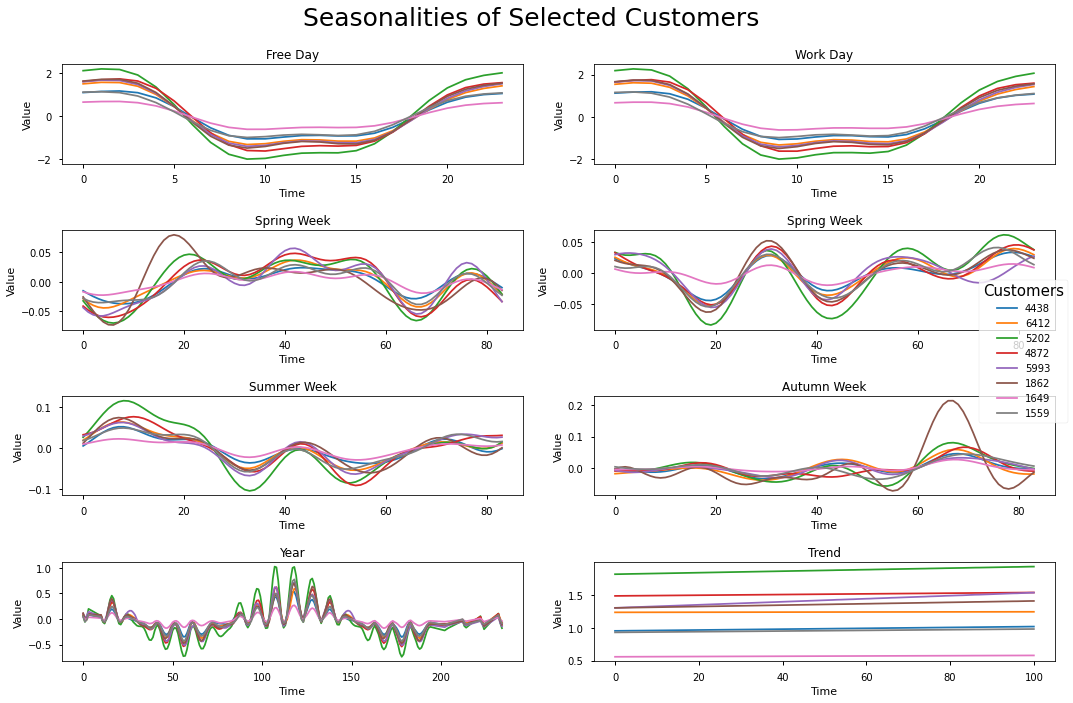

In [42]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for dim, name, ax in zip(
    [
        free_day,
        work_day,
        spring_week,
        summer_week,
        autumn_week,
        winter_week,
        year,
        trend,
    ],
    (
        "Free Day",
        "Work Day",
        "Spring Week",
        "Spring Week",
        "Summer Week",
        "Autumn Week",
        "Year",
        "Trend",
    ),
    chain(*axs),
):
    dim.iloc[selected_indices].T.plot(
        title=name, xlabel="Time", ylabel="Value", legend=False, ax=ax
    )


handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="center right", title="Customers")

fig.suptitle("Seasonalities of Selected Customers")

plt.tight_layout()

plt.savefig("../thesis/img/selected-seasonalities.png")

plt.show()

After the inspection of our datasets, we can add new prototypes. In this example, we are using the data points closest to the cluster centers in K-means. 

In [43]:
# Data points closest to the cluster centers in K-means.
feature_data = mcfdtw.add_prototypes(X=dimensions, indices=repeat(closest))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [44]:
# Manual adding
# feature_data = mcfdtw.add_prototypes(X=dimensions, indices=repeat([1023, 525, 867]))

In [45]:
# Random prototypes from selection
# np.random.seed(42)
# feature_data = mcfdtw.add_prototypes(
#     X=dimensions,
#     indices=repeat(np.random.choice(selected_indices, size=3, replace=False)),
# )

In [46]:
feature_data.shape

(5000, 320)

After adding new prototypes, we have to recompute PCA and UMAP with newly selected prototypes.

In [47]:
fdtw_data = np.arcsinh(
    np.hstack(
        [
            feature_data,
            year_stats.iloc[random_ts.index],
            year_diff_stats.iloc[random_ts.index],
        ]
    )
)

## Working With the Entire Dataset

Once we are satisfied with the selected prototypes, we can apply the MCFDTW transformation to the entire dataset. And perform clustering and anomaly detection.

In [48]:
from umap import plot as umap_plot

In [49]:
full_dimensions = [
    free_day,
    work_day,
    spring_week,
    summer_week,
    autumn_week,
    winter_week,
    year,
    trend,
]

full_dimensions = [
    x.sub(x.mean(axis=1), axis=0).div(x.std(axis=1), axis=0) for x in full_dimensions
]

In [50]:
full_feature_data = mcfdtw.transform(full_dimensions)

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

  0%|          | 0/12373 [00:00<?, ?it/s]

In [51]:
full_fdtw_data = np.arcsinh(
    np.hstack(
        [
            full_feature_data,
            year_stats,
            year_diff_stats,
        ]
    )
)

In [52]:
full_fdtw_data.shape

(12373, 328)

In [53]:
X_full_scaled = scaler.fit_transform(full_fdtw_data)

In [54]:
pca_full = PCA(n_components=50, random_state=42)
umap_high_full = UMAP(
    n_components=10, metric="manhattan", densmap=True, random_state=42
)
umap_full = UMAP(n_components=2, densmap=True, random_state=42)

In [55]:
X_pca_full = pca_full.fit_transform(full_fdtw_data)

In [56]:
start_time = time.time()
print("Transforming UMAP - high...")
X_umap_high_full = umap_high_full.fit_transform(X_pca_full)
print(f"Done {time.time() - start_time}")

Transforming UMAP - high...
Done 68.88855457305908


In [57]:
start_time = time.time()
print("Transforming UMAP - 2...")
X_umap_full = umap_full.fit_transform(X_umap_high_full)
print(f"Done {time.time() - start_time}")

Transforming UMAP - 2...
Done 56.74626016616821


In [58]:
kmeans_full = KMeans(n_clusters=10, random_state=42)
hdbscan_full = HDBSCAN(min_cluster_size=50)

In [59]:
p_km_full = kmeans_full.fit_predict(X_pca_full)

In [60]:
np.unique(p_km_full, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1752,  981, 1774, 1764,  939, 1196,  880,  288, 1671, 1128]))

In [61]:
p_hdb_full = hdbscan_full.fit_predict(X_umap_high_full)

In [62]:
np.unique(p_hdb_full, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([1301, 6138,   91, 1980,  105, 2031,  135,  592]))

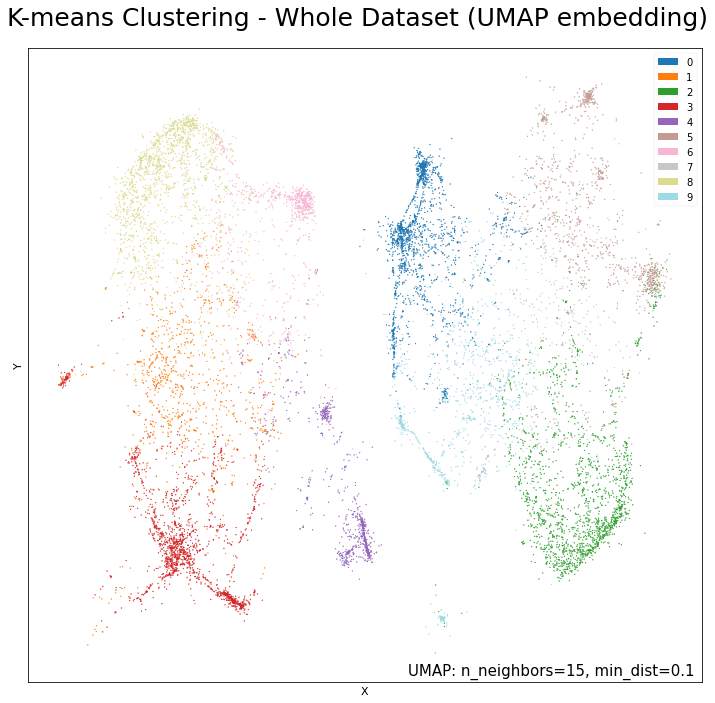

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

umap_plot.points(
    umap_full,
    width=600,
    height=600,
    color_key_cmap="tab20",
    labels=p_km_full,
    ax=ax,
)

plt.xlabel("X")
plt.ylabel("Y")

fig.suptitle("K-means Clustering - Whole Dataset (UMAP embedding)")

plt.tight_layout()

plt.savefig("../thesis/img/all-data-umap-kmeans.png")

plt.show()

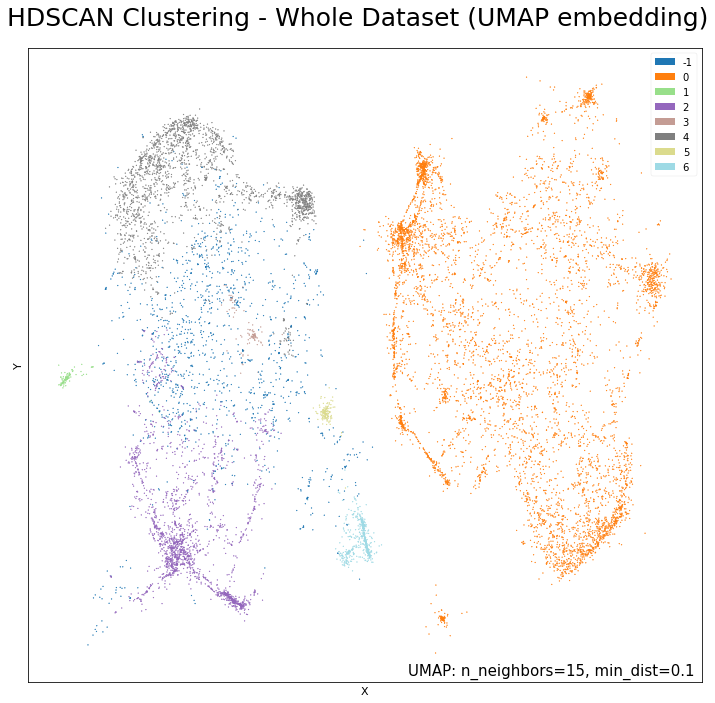

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))

umap_plot.points(
    umap_full, width=600, height=600, color_key_cmap="tab20", labels=p_hdb_full, ax=ax
)

plt.xlabel("X")
plt.ylabel("Y")

fig.suptitle("HDSCAN Clustering - Whole Dataset (UMAP embedding)")

plt.tight_layout()

plt.savefig("../thesis/img/all-data-umap-hdbscan.png")

plt.show()

### Anomaly Detection

In [65]:
loda = LODA(n_estimators=1000, random_state=42)
iforest = IsolationForest(n_estimators=1000, random_state=42)

In [66]:
loda.fit(X_pca_full)

LODA(random_state=42)

In [67]:
anomaly_score_loda = loda.score_samples(X_pca_full)

In [68]:
iforest.fit(X_pca_full)

IsolationForest(n_estimators=1000, random_state=42)

In [69]:
anomaly_score_iforest = iforest.score_samples(X_pca_full)

In [70]:
most_loda = np.argsort(anomaly_score_loda)[:8]

In [71]:
most_isoforest = np.argsort(anomaly_score_iforest)[:8]

In [72]:
anomal_joined, anom_count = np.unique(
    np.concatenate((most_loda, most_isoforest)), return_counts=True
)

anomal_joined = anomal_joined[np.argsort(anom_count)[::-1]]
anom_count = anom_count[np.argsort(anom_count)[::-1]]

In [73]:
anomal_joined

array([ 333, 7854, 7472, 6377, 5080, 4814, 4746, 2911, 1308, 1241, 1239,
        278,  208,  155,  148])

In [74]:
# Converting datetime into a timestamp for lttob downsampling
ts_series = time_series.columns.astype("int64") // 10 ** 9

anom_ts_data = []

# Downsampling anoumalous time series for quick visualization
for anom_ser in anomal_joined:
    time_s, val_s = downsample(
        np.vstack((ts_series, time_series.iloc[anom_ser].values)).T, 500
    ).T

    anom_frame = pd.DataFrame(np.vstack((time_s, val_s)).T, columns=["Time", "value"])
    anom_frame["Label"] = anom_ser
    anom_frame["Time"] = pd.to_datetime(anom_frame["Time"] * 10 ** 9)
    anom_ts_data.append(anom_frame)

In [75]:
join_anom_ts = pd.concat(anom_ts_data).pivot(
    index="Time", columns="Label", values="value"
)

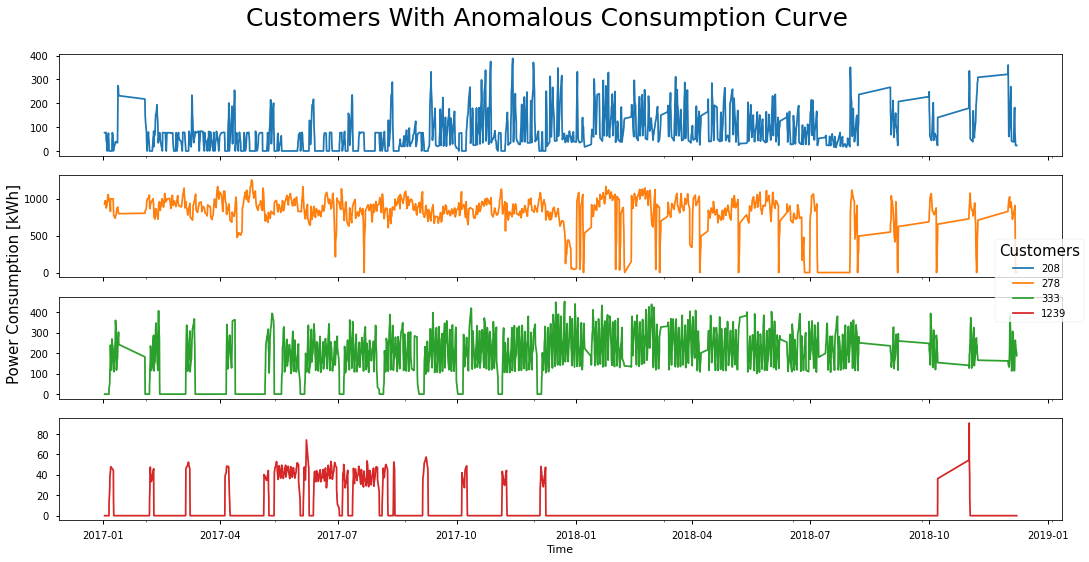

In [76]:
fig, axs = plt.subplots(4, sharex=True, figsize=(15, 8))

axs = join_anom_ts.iloc[:, 2:6].interpolate().plot(subplots=True, legend=False, ax=axs)

hl = [ax.get_legend_handles_labels() for ax in axs]

handles = [x[0] for x, _ in hl]
labels = [y[0] for _, y in hl]

fig.legend(handles, labels, loc="center right", title="Customers")
fig.text(0.00, 0.5, "Power Consumption [kWh]", va="center", rotation="vertical")

fig.suptitle("Customers With Anomalous Consumption Curve")


plt.tight_layout()
plt.savefig("../thesis/img/anomalous-users.png")

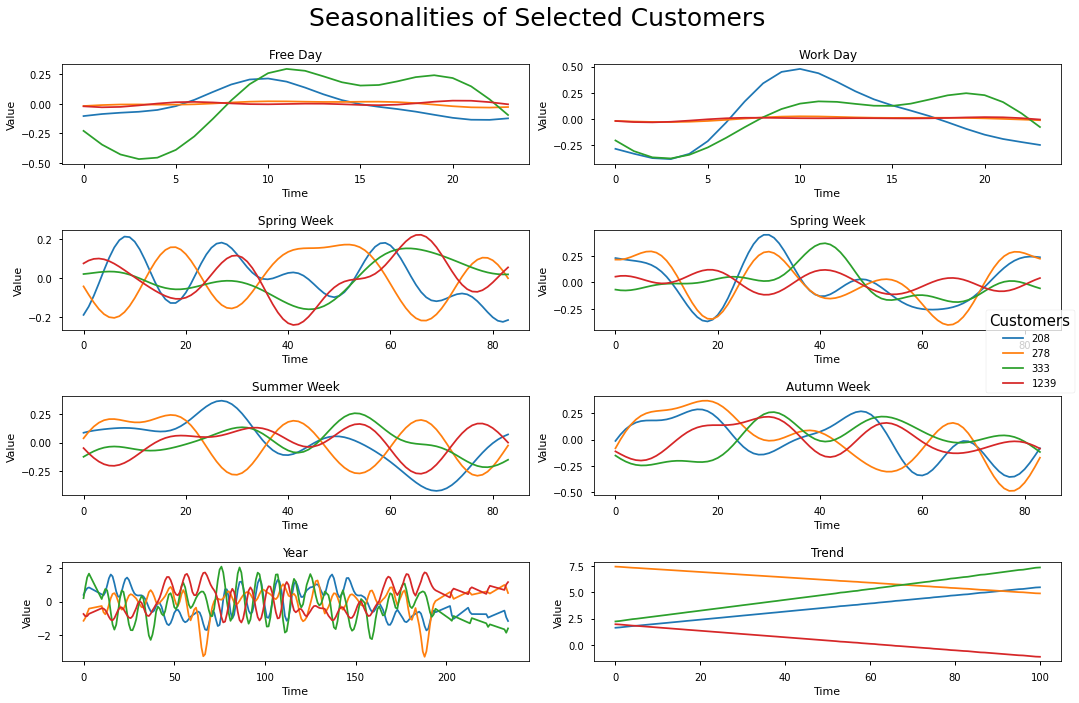

In [77]:
fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for dim, name, ax in zip(
    [
        free_day,
        work_day,
        spring_week,
        summer_week,
        autumn_week,
        winter_week,
        year,
        trend,
    ],
    (
        "Free Day",
        "Work Day",
        "Spring Week",
        "Spring Week",
        "Summer Week",
        "Autumn Week",
        "Year",
        "Trend",
    ),
    chain(*axs),
):
    dim.iloc[join_anom_ts.iloc[:, 2:6].columns].T.plot(
        title=name, xlabel="Time", ylabel="Value", legend=False, ax=ax
    )


handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="center right", title="Customers")

fig.suptitle("Seasonalities of Selected Customers")

plt.tight_layout()